# ICC Cricket World Cup 2019 - Batting Impact
I have recently been thinking about cricket metrics, and the best way that we can measure how impactful a batsman is. This comes from recently seeing a fantastic thread on Twitter from [Dan Weston](https://twitter.com/SAAdvantage) about the PSL, as well as the recent discussions about where Moeen Ali should bat for England given his power hitting against spin, and where most of the spin overs are in a T20 match.  

I thought that I would apply these ideas and metrics to the top 50 run scorers from last year's ICC Cricket World Cup.  

I got these summary statistics from [ESPNCricInfo](http://stats.espncricinfo.com/ci/engine/records/batting/most_runs_career.html?id=12357;type=tournament). I have written a web scraper that pulls the data from that page and saves it as a csv so it is easier for me to import into Kaggle.  

All the details about the web scraper can be found in my [Cricketer Analysis repository](https://github.com/willcanniford/cricketer-analysis) on Github. 

In [1]:
# Imports for loading and cleaning data
import pandas as pd
import re
import numpy as np

# Imports for visualisations
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Imports for batsman grouping and classification
from sklearn.cluster import KMeans
from sklearn import preprocessing 

## Loading and preparing the data

In [2]:
world_cup_batting_raw = pd.read_csv("../input/world_cup_batting_raw.csv")
df = world_cup_batting_raw.loc[:, ['Player','Runs', 'BF','SR','4s','6s']].copy()
df.head()

,Player,Runs,BF,SR,4s,6s
0,RG Sharma (INDIA),648,659,98.33,67,14
1,DA Warner (AUS),647,724,89.36,66,8
2,Shakib Al Hasan (BDESH),606,631,96.03,60,2
3,KS Williamson (NZ),578,771,74.96,50,3
4,JE Root (ENG),556,621,89.53,48,2


### Clean `Player` column
In the raw form, straight from the website, the `Player` column contains the country in brackets after the player's name. I'd like to separate that out into its own column (`Country`) and remove that from `Player`. I'm going to write 2 simple regex functions that we can `apply` to the `pd.Series` to achieve this. 

In [3]:
def extract_country(player_string):
    regex = re.compile(r'.* \(([A-Z]*)\)')
    return(regex.search(player_string).group(1))

def clean_player_name(player_string):
    regex = re.compile(r'([a-zA-Z \-]*)\s\([A-Z]*\)')
    return(regex.search(player_string).group(1))

In [4]:
df['Country'] = df.Player.apply(extract_country) # Create separate `Country` column
df['Player'] = df.Player.apply(clean_player_name) # Clean and replace `Player`

In [5]:
df.head() # Inspect new format 

,Player,Runs,BF,SR,4s,6s,Country
0,RG Sharma,648,659,98.33,67,14,INDIA
1,DA Warner,647,724,89.36,66,8,AUS
2,Shakib Al Hasan,606,631,96.03,60,2,BDESH
3,KS Williamson,578,771,74.96,50,3,NZ
4,JE Root,556,621,89.53,48,2,ENG


### Derive boundary-related metrics
The data as it currently stands just has the basic summary statistics for those individuals so I am going to derive some new ones that are based around the boundary hitting (using 4s and 6s), and work out the strike rate of the batsman if you remove the boundary balls from their stats.  

We will use some of these metrics later to classify the batsman into groups using `sklearn`. 

In [6]:
df['BoundaryRuns'] = df['4s'] * 4 + df['6s'] * 6
df['NonBoundaryRuns'] = df['Runs'] - df['BoundaryRuns']
df['TotalBoundaries'] = df['4s'] + df['6s']
df['NonBoundaryBalls'] = df['BF'] - df['TotalBoundaries']
df['RunsFromBoundary %'] = round(df['BoundaryRuns'] / df['Runs'] * 100, 2)
df['Boundary %'] = round(df['TotalBoundaries'] / df['BF'] * 100, 2)
df['NonBoundaryStrikeRate'] = round(df['NonBoundaryRuns'] / df['NonBoundaryBalls'] * 100, 2)
df['Boundary6 %'] = round(df['6s'] / (df['6s'] + df['4s']) * 100, 2)

In [7]:
df.head() # Inspect new format 

,Player,Runs,BF,SR,4s,6s,Country,BoundaryRuns,NonBoundaryRuns,TotalBoundaries,NonBoundaryBalls,RunsFromBoundary %,Boundary %,NonBoundaryStrikeRate,Boundary6 %
0,RG Sharma,648,659,98.33,67,14,INDIA,352,296,81,578,54.32,12.29,51.21,17.28
1,DA Warner,647,724,89.36,66,8,AUS,312,335,74,650,48.22,10.22,51.54,10.81
2,Shakib Al Hasan,606,631,96.03,60,2,BDESH,252,354,62,569,41.58,9.83,62.21,3.23
3,KS Williamson,578,771,74.96,50,3,NZ,218,360,53,718,37.72,6.87,50.14,5.66
4,JE Root,556,621,89.53,48,2,ENG,204,352,50,571,36.69,8.05,61.65,4.00


## Visualising Batsman
Comparing the percentage of the balls that a batsman faced that were hit for boundaries, and the strike rate of the batsman in balls that weren't boundaries can give us a slight indication of how they approach the game.  

For example, Chris Gayle is known for his power hitting, and also his lack of running between the wickets. It therefore makes sense that his `NonBoundaryStrikeRate` is lowest of any batsman in this dataset.  

In this particular visualisation, you want to be aiming for the top right, as this indicates a lot of boundaries hit, as well as the ability to score off the balls that you don't connect with. Unfortunately this doesn't have context to the runs, as late over hitting yields both more aggressive batting, but also spread fields that allow for easy singles if you don't fully connect with the ball. 

In [8]:
fig = px.scatter(df, 
                 x='Boundary %', 
                 y='NonBoundaryStrikeRate', 
                 color='Country', 
                 hover_name='Player', 
                 size='Runs')

fig.update_layout(
    height=500,
    title_text='ICC Cricket World Cup 2019 - Boundary Impact'
)
fig.show()

Looking at both `Boundary %` and the `Boundary6 %` you can see the prolific 6 hitters, and the risk takers. Those that are scoring boundaries frequently, and big hits when they do go for it.  

Chris Gayle rises here, as his strong arms allow for more than average 6 hitting in the top half of the graph. Morgan sits at the very top of the graph, and his big hitting over the leg side is well known in international cricket; he was at it again in [South Africa](https://www.espncricinfo.com/series/19286/scorecard/1185315/south-africa-vs-england-3rd-t20i-england-in-sa-2019-20).

In [9]:
fig = px.scatter(df, 
                 x='Boundary %', 
                 y='Boundary6 %', 
                 color='Country', 
                 hover_name='Player', 
                 size='Runs')

fig.update_layout(
    height=500,
    title_text='ICC Cricket World Cup 2019 - 6 Hitting Impact'
)
fig.show()

## Scaling and classifying batsman data
Firstly, I need to decide which metrics that we have defined are going to help us to group the batsman into their groups. I don't think any of the summary statistics are appropriate here, as we are trying to define the style in which the batsman performs, rather than the amount of runs that they happened to score in this tournament.  

I have decided that I will work with just 3 groups in this example, which might not be the optimal grouping but I am working with only 50 players. 

In [10]:
grouping_columns = ['SR', 'RunsFromBoundary %', 'Boundary %', 'NonBoundaryStrikeRate', 'Boundary6 %']
df_chosen = df.loc[:,grouping_columns]

- `SR` - What is the general pace of the batsman's scoring? 
- `RunsFromBoundary %` - How reliant is the player on hitting boundaries for their runs? 
- `Boundary %` - How frequently do they find the rope? 
- `NonBoundaryStrikeRate` - Do they have other options and still able to score when not hitting boundaries?
- `Boundary6 %` - Do they take risks to gain maximum runs for a delivery? 

In [11]:
df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df_chosen))
df_scaled.columns = grouping_columns
df_scaled.head()

,SR,RunsFromBoundary %,Boundary %,NonBoundaryStrikeRate,Boundary6 %
0,0.416037,0.612935,0.573925,-0.072033,0.249427
1,-0.132878,-0.015389,-0.065554,-0.037602,-0.359827
2,0.275290,-0.699335,-0.186036,1.075653,-1.073605
3,-1.014079,-1.096930,-1.100460,-0.183671,-0.844782
4,-0.122475,-1.203024,-0.735926,1.017225,-1.001097


In [12]:
# Instantiate a model with 3 centers
kmeans = KMeans(3)

# Then fit the model to your data using the fit method
model = kmeans.fit(df_scaled)

# Finally predict the labels on the same data to show the category that point belongs to
labels = model.predict(df_scaled)

In [13]:
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
labels_group = pd.Series(labels, dtype="category").map({0:'A', 1:'B',2:'C'})
df['Batting Classification'] = labels_group

In [15]:
fig = px.scatter(df, 
                 x='Boundary %', 
                 y='NonBoundaryStrikeRate', 
                 color='Batting Classification', 
                 hover_name='Player', 
                 size='Runs')

fig.update_layout(
    height=500,
    title_text='ICC Cricket World Cup 2019 - Batting Classifications'
)
fig.show()

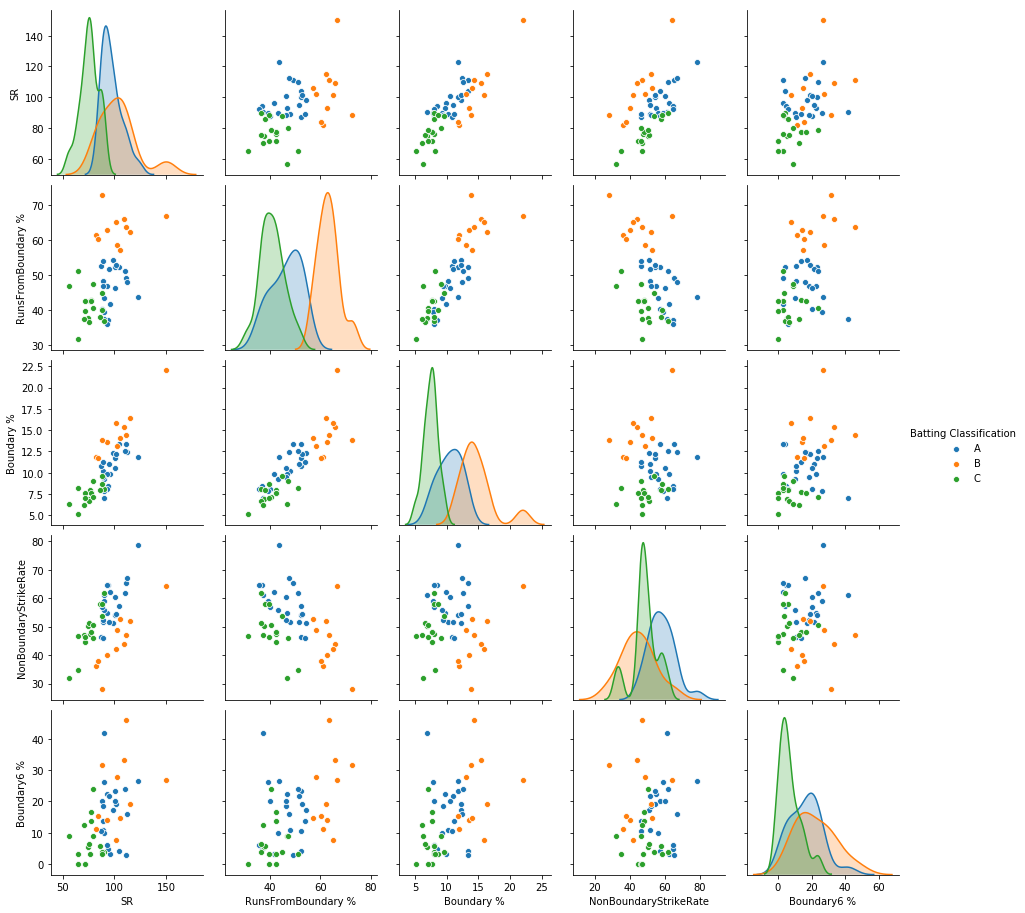

In [16]:
df_pair = df_chosen.copy()
df_pair['Batting Classification'] = labels_group
sns.pairplot(df_pair, hue='Batting Classification')
plt.show()

The fairly simply batting classification seems to have grouped them fairly sensibly (when looking at the visuals) when we use those 5 metrics but there are some plots where all the groups are muddied in the water, the `Boundary6 %` doesn't seem to separate out the batsman as well as the `Boundary %` for example. 

**Group A**  
RG Sharma, JM Bairstow, AJ Finch, JJ Roy, EJG Morgan, N Pooran, SO Hetmyer, CH Gayle, Zadran, WIA Fernando, Fakhar Zaman, MJ Guptill, GJ Maxwell, JO Holder, Soumya Sarkar

**Group B**  
KS Williamson, KL Rahul, LRPL Taylor, Imam-ul-Haq, SD Hope, Rahmat Shah, AD Mathews, Tamim Iqbal, JDS Neesham, FDM Karunaratne, HM Amla, Hashmatullah Shahidi, Gulbadin Naib

**Group C**  
DA Warner, Shakib Al Hasan, JE Root, Babar Azam, BA Stokes, V Kohli, F du Plessis, SPD Smith, AT Carey, Mushfiqur Rahim, UT Khawaja, JC Buttler, van der Dussen, Q de Kock, MDKJ Perera, MS Dhoni, Mohammad Hafeez, HH Pandya, Mahmudullah, Haris Sohail, C de Grandhomme, Liton Das

### Attempting to find a better `K` value
I'm not convinced of the value of `K` being 3. Let's use the Elbow Method and the Silhouette method to try and determine what the optimal value of `K` is.  

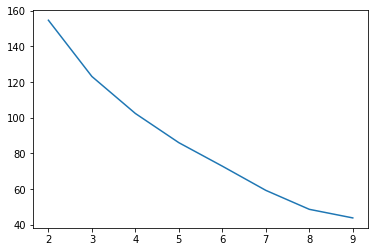

In [17]:
scores = []
clusters = [x for x in range(2,10)]
for i in clusters:
    kmeans = KMeans(i)
    model = kmeans.fit(df_scaled)
    scores.append(np.abs(model.score(df_scaled)))
    
plt.plot(clusters, scores)  
plt.show()

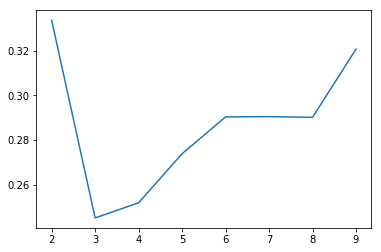

In [18]:
from sklearn.metrics import silhouette_score

sil = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in clusters:
  kmeans = KMeans(n_clusters = k).fit(df_scaled)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_scaled, labels, metric = 'euclidean'))

plt.plot(clusters, sil)
plt.show()

The elbow method hasn't told us what the optimal level is, and the Silhouette method is just showing us that maybe more clusters would be better. I'm going to try with 8, but given the small sample size that we are clustering here, this may be too granular. 

In [19]:
kmeans = KMeans(8)
model = kmeans.fit(df_scaled)
labels = model.predict(df_scaled)
df_8_clusters = df.copy()
labels_group = pd.Series(labels, dtype="category").map({0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H'})
df_8_clusters['Batting Classification'] = labels_group
fig = px.scatter(df_8_clusters, 
                 x='Boundary %', 
                 y='NonBoundaryStrikeRate', 
                 color='Batting Classification', 
                 hover_name='Player', 
                 size='Runs')

fig.update_layout(
    height=500,
    title_text='ICC Cricket World Cup 2019 - Batting Classifications'
)
fig.show()

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning:

Data must have variance to compute a kernel density estimate.



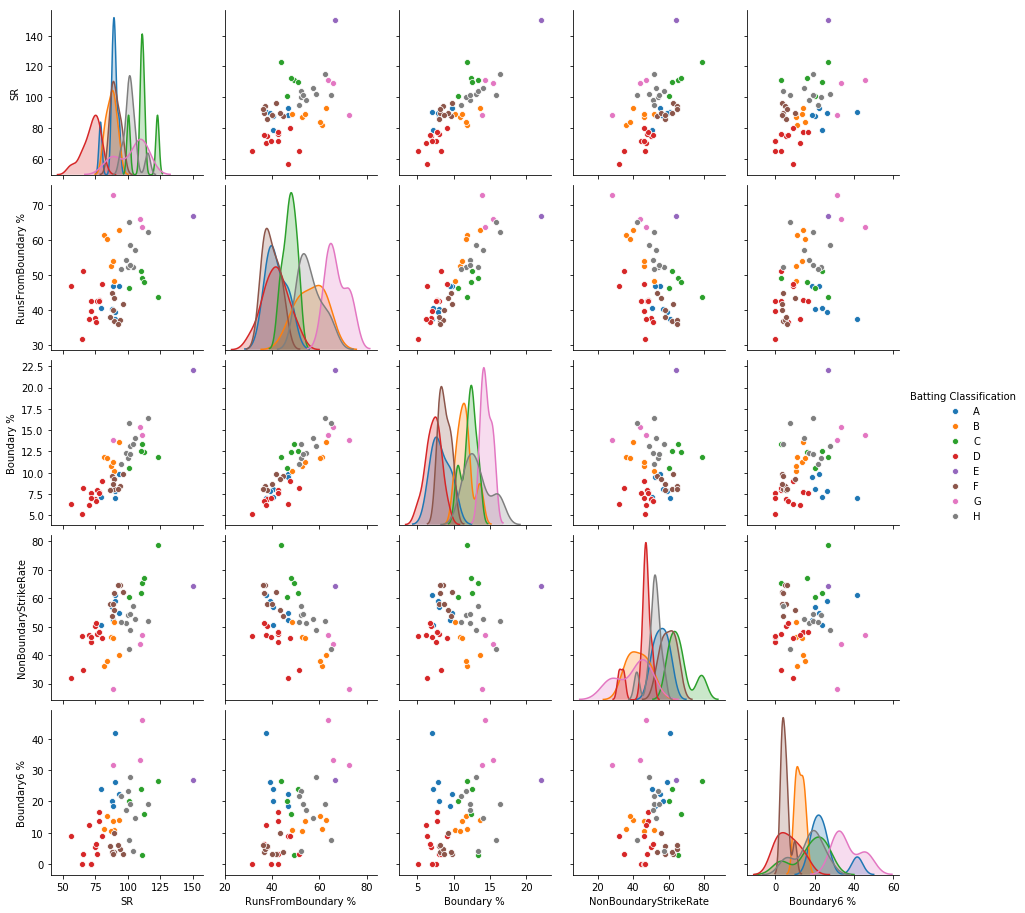

In [20]:
df_pair = df_chosen.copy()
df_pair['Batting Classification'] = labels_group
sns.pairplot(df_pair, hue='Batting Classification')
plt.show()

I suppose the most notable difference here is that this has completely isolated Maxwell.

- - -

I might well continue this, and try to improve the classification system through trying out other metric combinations and group sizes.  

If you've got any **suggestions** then please let me know, or any ideas or tips about how I can improve this kernel.  

If you've enjoyed reading this then please consider **upvoting** this kernel! 